## Applied Machine Learning HW3
#### Hojin Lee (hl3328) & Hyuk Joon Kwon (hk3084)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import category_encoders as ce

In [2]:
df = pd.read_csv(r'vehicles.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 25 columns):
id              509577 non-null int64
url             509577 non-null object
region          509577 non-null object
region_url      509577 non-null object
price           509577 non-null int64
year            508050 non-null float64
manufacturer    486813 non-null object
model           501588 non-null object
condition       277643 non-null object
cylinders       309894 non-null object
fuel            505592 non-null object
odometer        417253 non-null float64
title_status    506515 non-null object
transmission    505858 non-null object
vin             302152 non-null object
drive           365434 non-null object
size            167574 non-null object
type            368046 non-null object
paint_color     344871 non-null object
image_url       509563 non-null object
description     509561 non-null object
county          0 non-null float64
state           509577 non-null obj

We can see that couple columns are missing a lot of data, such as condition, cyclinders, odometer, drive, size, type and county. Further analsysis is required on these columns.

In [4]:
dropna = True
sample_size = 10000
lower_bound, upper_bound = 100, 50000


## Task 1 Identify Features

We will drop following features: id, url, region_url, image_url, county, vin, description, lat and long. ID and VIN are features are identifiers of data points and they might leak information about the target. url, region_url and image_url do not help us with predicting data since we cannot extract information from them without further analysis.Feature county was excluded as all data points were missing. lat and long was excluded as we have region and state information. Lastly, description was removed since it is too costly to extract information from it.

On the other hand, Price was selected as the target column because the price of a car is what needs to be predicted. 


In [5]:
drop_cols = ['id', 'url', 'region_url', 'image_url', 'county', 'vin', 'description', 'lat', 'long','state','title_status']
df_drop = df.drop(drop_cols, axis=1)


In [6]:
if dropna:
    df_clean = df_drop.dropna()
    print('dropped null value')
else:
    df_clean = df_drop
    print('did not dropped null value')

print('total data points: ', len(df_clean))

dropped null value
total data points:  106954


In [7]:
#sampling 10,000 data points 
df_sample = df_clean.sample(n=sample_size, random_state=1)


#### Assemble a dataset with features and columns

In [8]:
X = df_sample.loc[:, df_sample.columns != 'price']
y = df_sample['price'] #target as we are trying to predict the price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Task 2 Preprocessing and Baseline Model

In [9]:
categorical = X.dtypes == object

cat_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NaN'),
    OneHotEncoder(handle_unknown='ignore'))

cont_preprocessing = make_pipeline(
    SimpleImputer())

cont_preprocessing_scale = make_pipeline(
    SimpleImputer(),
    StandardScaler())

preprocess = make_column_transformer(
    (cat_preprocessing, make_column_selector(dtype_include='object')),
    remainder=cont_preprocessing)

preprocess_scale = make_column_transformer(
    (cat_preprocessing, make_column_selector(dtype_include='object')),
    remainder=cont_preprocessing_scale)

def pipeline_prediction(X_train, y_train, preprocess, regression, cv=5):
    OLR_pipe = make_pipeline(preprocess, regression)
    scores_olr = cross_val_score(OLR_pipe, X_train, y_train, cv=cv)
    return np.mean(scores_olr)

In [10]:
results_dict= {}
methods = [LinearRegression(), Ridge()]
processors = [preprocess, preprocess_scale]
method_name = ['Linear_regression', 'Ridge']
processors_name = ['without_scaler', 'with_scaler']

processor_counter = 0

for processor in processors:
    method_counter = 0
    results_dict[processors_name[processor_counter]] = {}
    
    for method in methods:
        
        results_dict[processors_name[processor_counter]][method_name[method_counter]] = pipeline_prediction(X_train, y_train, processor,method)
        method_counter += 1
        
    processor_counter += 1
        
results_df = pd.DataFrame.from_dict(results_dict)
print(tabulate(results_df, headers='keys', tablefmt='psql'))



+-------------------+------------------+---------------+
|                   |   without_scaler |   with_scaler |
|-------------------+------------------+---------------|
| Linear_regression |        -46.7541  |      -74.3642 |
| Ridge             |         -0.14832 |      -43.918  |
+-------------------+------------------+---------------+


## Task 3 Feature Engineering


We first need to investigate our target variable: price.

  Price    Count
-------  -------
      0      444
      1      167
   4500      129
   3500      119
   5995      112


Text(0.5, 1.0, 'Histogram for price in log scale')

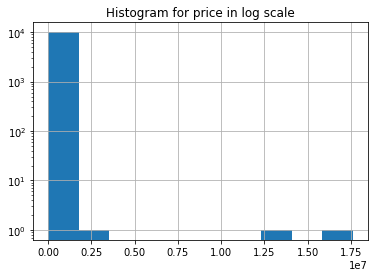

In [11]:
price_value_count = pd.DataFrame(df_sample.price.value_counts(dropna=False))
print(tabulate(price_value_count.head(), headers=["Price","Count"]))

ax = df_sample.price.hist()
ax.set_yscale('log')
ax.set_title('Histogram for price in log scale')


From the histogram above, we can see that there exist outliers and 0 or null value for our target variable, price. In order to remedy this issue, we are going to remove these values from the table. 

In [12]:
df_sample = df_sample[(df_sample['price'] > lower_bound) & (df_sample['price'] < upper_bound)]

After removing the upper and lower bound price data has a better distribution

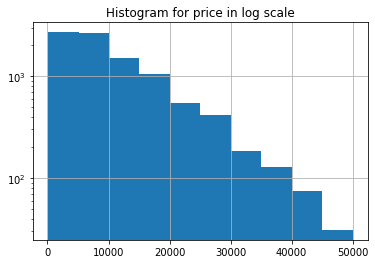

In [13]:
ax = df_sample.price.hist()
ax.set_yscale('log')
ax.set_title('Histogram for price in log scale');

#### Preprocessing Pipelines with sample dataset

In [14]:
X = df_sample.loc[:, df_sample.columns != 'price']
y = df_sample['price'] #target as we are trying to predict the price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#adding polynomial features
cont_preprocessing_scale_poly = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    PolynomialFeatures())

preprocess_scale_poly = make_column_transformer(
    (cat_preprocessing, make_column_selector(dtype_include='object')),
    remainder=cont_preprocessing_scale_poly)


Next, we want to check how many unique values exist within a column. For columns with too many unique values, we want to perform target encoing instead of one-hot encoding for the performance of learning.

In [15]:
unique_val = {}
for col in list(df_sample.select_dtypes(include=['object']).columns):
    unique_val[col] = len(df[col].unique())
unique_df = pd.DataFrame.from_dict(unique_val,orient='index').reset_index()
unique_df.columns = ['feature', 'count']
unique_df = unique_df.sort_values(by=['count'], ascending=False)
print(tabulate(unique_df, headers='keys'))

    feature         count
--  ------------  -------
 2  model           35853
 0  region            403
 1  manufacturer       44
 9  type               14
10  paint_color        13
 4  cylinders           9
 3  condition           7
 5  fuel                6
 8  size                5
 6  transmission        4
 7  drive               4


The targets we have selected for target encoding are the columns 'model' and 'region'

In [16]:
# target encoding model and region
te = ce.TargetEncoder(cols=['model','region']).fit(X_train, y_train)
X_train_te = te.transform(X_train)
X_test_te = te.transform(X_test)

Target Encoding Two of the columns and adding polynomal features improves the model a lot

In [17]:
results_dict= {}
methods = [LinearRegression(), Ridge()]
processors = [preprocess, preprocess_scale, preprocess_scale_poly]
method_name = ['Linear_regression', 'Ridge']
processors_name = ['without_scaler', 'with_scaler', 'with_scaler & polynomial']

processor_counter = 0

for processor in processors:
    method_counter = 0
    results_dict[processors_name[processor_counter]] = {}
    
    for method in methods:
        
        results_dict[processors_name[processor_counter]][method_name[method_counter]] = pipeline_prediction(X_train_te, y_train, processor,method)
        method_counter += 1
        
    processor_counter += 1
        
results_df = pd.DataFrame.from_dict(results_dict)
print(tabulate(results_df, headers='keys', tablefmt='psql'))

+-------------------+------------------+---------------+----------------------------+
|                   |   without_scaler |   with_scaler |   with_scaler & polynomial |
|-------------------+------------------+---------------+----------------------------|
| Linear_regression |         0.608799 |      0.60888  |                   0.699323 |
| Ridge             |         0.465204 |      0.609092 |                   0.699847 |
+-------------------+------------------+---------------+----------------------------+


## Task 4 Any model

Using the preprocessing above, we have added tree based modesl, and Random Forest Regressor seemed to have the best performance.

In [30]:
results_dict= {}
methods = [LinearRegression(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor()]
processors = [preprocess, preprocess_scale, preprocess_scale_poly]
method_name = ['Linear Regression', 'Ridge', 'Decision Tree', 'Random Forest Regressor']
processors_name = ['without_scaler', 'with_scaler', 'with_scaler & polynomial']

processor_counter = 0

for processor in processors:
    method_counter = 0
    results_dict[processors_name[processor_counter]] = {}
    
    for method in methods:
        
        results_dict[processors_name[processor_counter]][method_name[method_counter]] = pipeline_prediction(X_train_te, y_train, processor,method)
        method_counter += 1
        
    processor_counter += 1
        
results_df = pd.DataFrame.from_dict(results_dict)
print(tabulate(results_df, headers='keys', tablefmt='psql'))


+-------------------------+------------------+---------------+----------------------------+
|                         |   without_scaler |   with_scaler |   with_scaler & polynomial |
|-------------------------+------------------+---------------+----------------------------|
| Linear Regression       |         0.608799 |      0.60888  |                   0.699323 |
| Ridge                   |         0.465204 |      0.609092 |                   0.699847 |
| Decision Tree           |         0.632976 |      0.641477 |                   0.625634 |
| Random Forest Regressor |         0.824344 |      0.824877 |                   0.816841 |
+-------------------------+------------------+---------------+----------------------------+


The random forest regressor seems to be the best so we we will perform grid serach on the random forest regressor. 

In [19]:
def grid_fun_scale_poly(model,param_grid,X,y):
    grid = GridSearchCV(make_pipeline(preprocess_scale_poly,model), param_grid, cv=5)
    grid.fit(X, y)
    return grid

def grid_fun_scale(model,param_grid,X,y):
    grid = GridSearchCV(make_pipeline(preprocess_scale,model), param_grid, cv=5)
    grid.fit(X, y)
    return grid

def grid_print(grid,X,y):
    print(grid.best_params_)
    print(grid.score(X, y))

By using grid search we can conlude the deafult settings ("auto") seems to be the best parameter. There is a big improvement in using the random forest regressor compared to ridge regression. 

In [20]:
rf = RandomForestRegressor(random_state = 42)
rf_grid = {'randomforestregressor__max_features': ['auto', 'sqrt', 'log2']}
grid_rf_poly = grid_fun_scale_poly(RandomForestRegressor(),rf_grid,X_train,y_train)
grid_print(grid_rf_poly, X_test,y_test)

{'randomforestregressor__max_features': 'auto'}
0.8039448654048919


## Task 5 Feature Selections

In [21]:
rf_regressor = RandomForestRegressor()
np.mean(cross_val_score(rf_regressor, preprocess.fit_transform(X_train_te), y_train, cv=10))


0.8267762867146912

In [22]:
# manually creating training df, so that we can extract feature names for Task 5 and 6.

categorical_var = list(X_train_te.select_dtypes(object).columns)
continuous_var = list(X_train_te.columns[X_train_te.dtypes != object])

if not dropna:
    #if we didn't drop missing values, run the code below for missing value imputation
    imputer = SimpleImputer(strategy='most_frequent')
    imputer = imputer.fit(X_train_te[categorical_var])
    cat_trans = imputer.transform(X_train_te[categorical_var])
    imputed_train_df_cat = pd.DataFrame(cat_trans, columns = categorical_var) 
    X_train_te = X_train_te.drop(categorical_var, axis=1)
    X_train_te = pd.concat([X_train_te.reset_index(), imputed_train_df_cat.reset_index()], axis=1)

#one hot encoding for categorical value
enc = OneHotEncoder()
enc = enc.fit(X_train_te[categorical_var])
cat_trans = enc.transform(X_train_te[categorical_var]).toarray()

X_train_cat = pd.DataFrame(cat_trans, columns = enc.get_feature_names()) 

if not dropna:
    #if we didn't drop missing values, run the code below for missing value imputation
    imputer = SimpleImputer()
    imputer = imputer.fit(X_train_te[continuous_var])
    con_trans = imputer.transform(X_train_te[continuous_var])
    imputed_train_df_con = pd.DataFrame(con_trans, columns = continuous_var) 
    X_train_te = X_train_te.drop(continuous_var, axis=1)
    X_train_te = pd.concat([X_train_te, imputed_train_df_con], axis=1)

#scaler for continuous value
scaler = StandardScaler()
scaler = scaler.fit(X_train_te[continuous_var])
con_trans = scaler.transform(X_train_te[continuous_var])

X_train_con = pd.DataFrame(con_trans, columns = [continuous_var]) 

train_df = pd.concat([X_train_cat, X_train_con], axis=1)


#### Random Forest before Feature Selection

In [23]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(train_df, y_train)
print('score:', rf_regressor.score(train_df, y_train))
print('CV score:', np.mean(cross_val_score(rf_regressor, train_df, y_train, cv=5)))

feature_importance = list(sorted(zip(map(lambda x: round(x, 4), rf_regressor.feature_importances_), train_df.columns), 
             reverse=True))

score: 0.9761130931899572
CV score: 0.8245037499976021


#### Feature Importance Plot

In [24]:
feature_plot = pd.DataFrame(feature_importance)
feature_plot[1][0] = "year"
feature_plot[1][1] = "model"
feature_plot[1][2] = "odometer"
feature_plot[1][5] = "region"
feature_plot = feature_plot.iloc[:20,:]

Text(0.5, 1.0, 'Top 20 feature importantce for random forest')

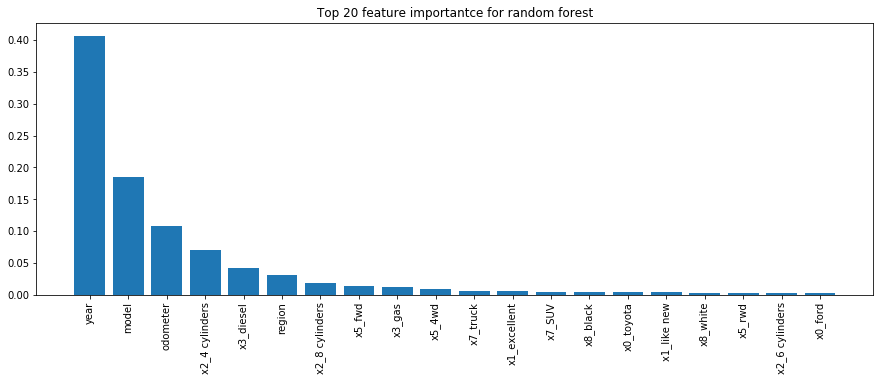

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feature_plot[1],feature_plot[0])
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Top 20 feature importantce for random forest')

In [26]:
top10_list = []
for i in feature_importance[:10]:
    top10_list.append(i[1])

print('top10_list',top10_list)

top10_list [('year',), ('model',), ('odometer',), 'x2_4 cylinders', 'x3_diesel', ('region',), 'x2_8 cylinders', 'x5_fwd', 'x3_gas', 'x5_4wd']


#### Random Forest with only top 10 features

Overall the score has decreased but only a small amount. We can observe that most of the information is preserved despite keeping only 10 best features.

In [27]:
rf_regressor.fit(train_df[top10_list], y_train)
print('score:', rf_regressor.score(train_df[top10_list], y_train))
print('CV score:', np.mean(cross_val_score(rf_regressor, train_df[top10_list], y_train, cv=5)))

score: 0.9720673467992316
CV score: 0.7983743430201897


## Task 6 An explainable model

To build an explanable model, we decided to use simple decision tree regressor.

In [28]:
tree_regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10)
np.mean(cross_val_score(tree_regressor, preprocess.fit_transform(X_train_te), y_train, cv=10))

0.6716845597089367

We can observe that with only 5 depth, we ended up in a decent cross-validation score using the tree regressor. At the below, we have plotted this tree, and as there were only 5 depth, the model is highly interpretable. For example, the root node was year and model and odometer seemed to be very important features. This result also corresponds to Task 5 which was to do feature selection by identifying the most important features.

score: 0.7094414755235856


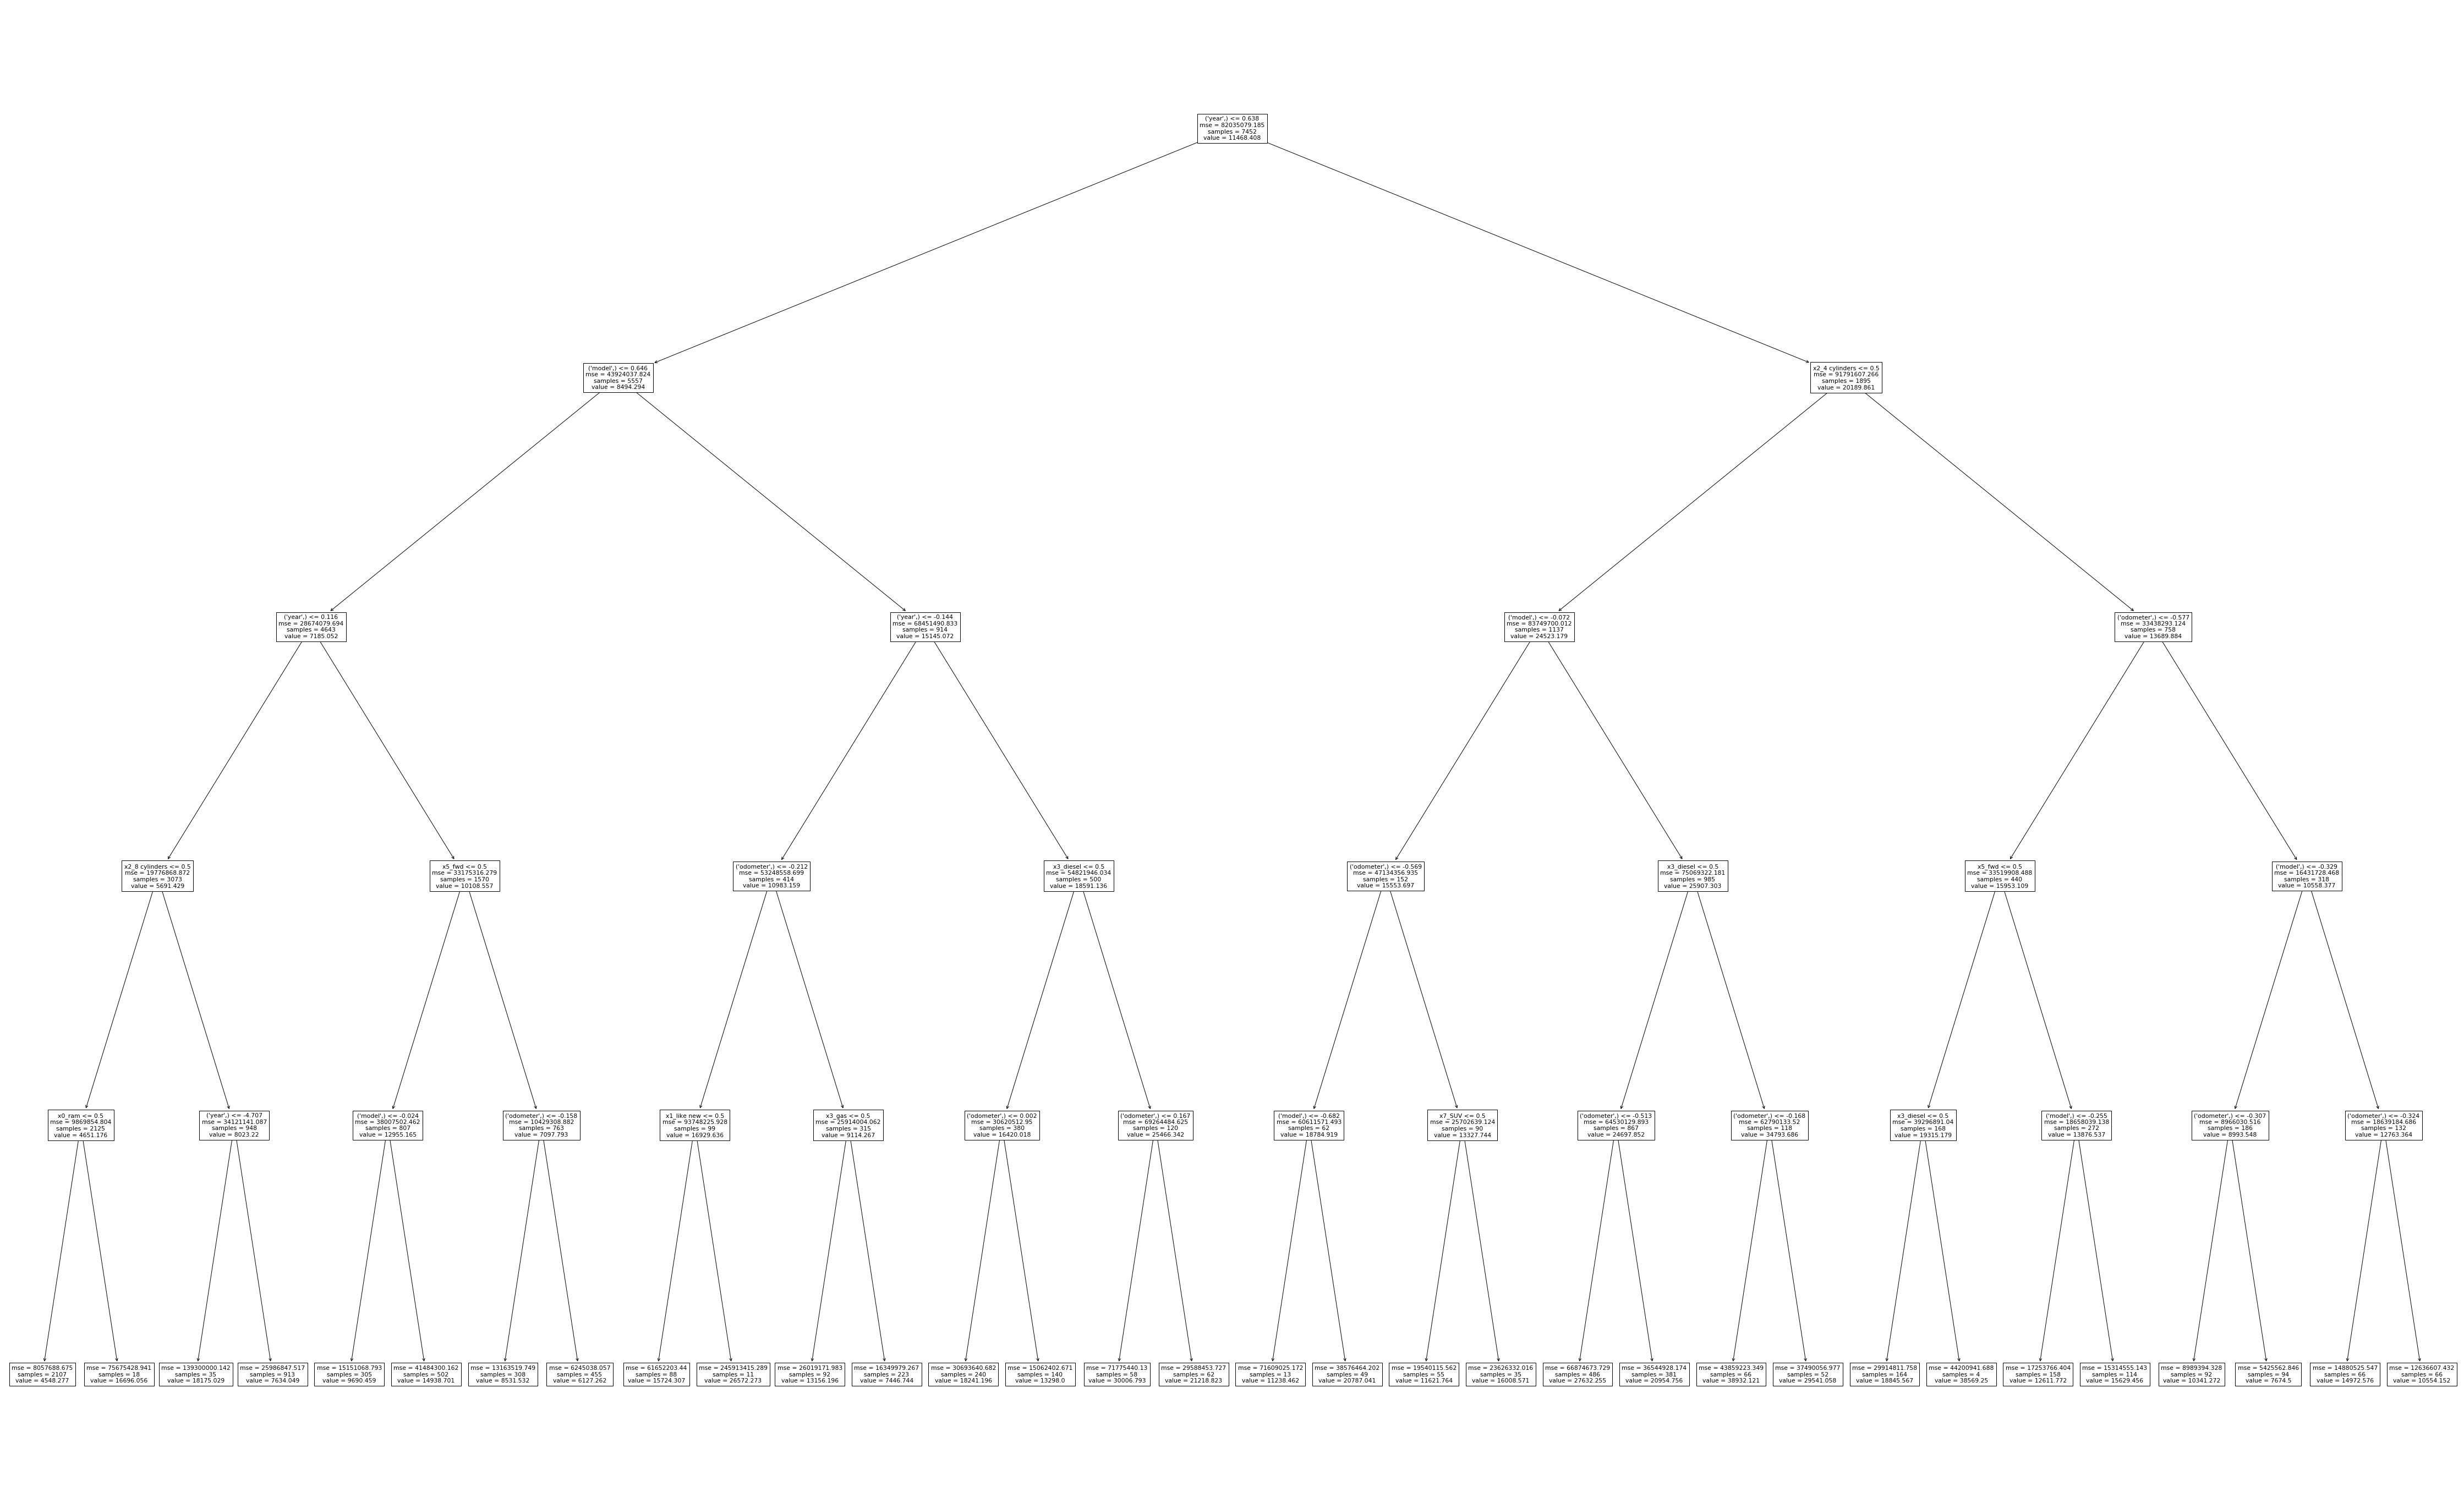

In [29]:
tree_regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10)
tree_regressor.fit(train_df, y_train)
print('score:',tree_regressor.score(train_df, y_train))

from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

from sklearn.tree import plot_tree
tree_dot = plot_tree(tree_regressor, feature_names=train_df.columns)
